# Memo for CTGAN Source Code Editing

This file is used to trace back the source code to understand the proper revisions or edits.

## Issue 1. Understanding how source code handle the column ID

I added the parameter `user_specified_col` into the `data_sampler.py` and the `ctgan.py` source codes. Test this minor change's influence on oversall code running. It runs well.

I hope the user_specified_col should be a list rather than a column id or a string to indicate only one column. I hope this modification can make CTGAN work on single or multiple user specified columns. Therefore, I need to check how source code handle the discrete column id.

In `data_sampler.py` file:  
```{python}
def sample_condvec(self, batch, user_specified_col=None):
        """Generate the conditional vector for training.
        ...
        """
        if self._n_discrete_columns == 0:
            return None 
        
        # PAN：If a user-specified column is provided, use its index
        if user_specified_col is not None:
            discrete_column_id = user_specified_col
        else:
            # original behavior: randomly select a column
            discrete_column_id = np.random.choice(np.arange(self._n_discrete_columns), batch)
```  
Note, `discrete_column_id` is drawn from the `self._n_discreate_columns`. In addition, the following code shows that the `discrete_column_id` should be the the index of one specific discrete column among all discrete columns rather than the index among the overall columns.  
```{python}
cond = np.zeros((batch, self._n_categories), dtype='float32')
mask = np.zeros((batch, self._n_discrete_columns), dtype='float32')
mask[np.arange(batch), discrete_column_id] = 1
```

Therefore, the modification should make the sampler to randomly select `discrete_column_id` from the user specified discrete columns rather than from all discrete columns when `user_specified_col` is not None.

From here, I suppose the newly-added parameter `user_specified_col` is a list containing all user defined discrete columns names (in string format). For example, `user_specified_col = ["sex", "country"]`. The modified code should be:

Here, I should figure out where `self._n_discrete_columns` comes from:  `_n_discrete_columns` ---> `self._n_discrete_columns = n_discrete_columns` ---> `column_info` as shown below:
```{python} 
n_discrete_columns = sum([
            1 for column_info in output_info if is_discrete_column(column_info)
        ])
```

From the `ctgan.py` file, seeking for instantiated object of data_sampler, I found that  
```{python}
self._data_sampler = DataSampler(
            train_data, self._transformer.output_info_list, self._log_frequency
        )
```  
That is: `self._n_discrete_columns` ---> `_n_discrete_columns` ---> `self._n_discrete_columns = n_discrete_columns` ---> `column_info` ---> `self._transformer.output_info_list` --->   
```{pyton}
        self._transformer = DataTransformer()
        self._transformer.fit(train_data, discrete_columns)

        train_data = self._transformer.transform(train_data)

        self._data_sampler = DataSampler(
            train_data, self._transformer.output_info_list, self._log_frequency
        )
```

Note, the continuous column will have two parts: the first is to transfrom using `tanh` to normalize and the second is to use the soeftmax. However, the discrete column will only have one parts like `[SpanInfo(dim=42, activation_fn='softmax')]` to indicate this is a discrete column with 42 unique categories.

Now, I plan to solely run the data transformer to check what it will return. See the section `Investigate the discrete_column_id` in the `Test_zone` for detail.

Now, I can confirm that the variable `n_discrete_columns` is just the summation of all discrete columns.

## Test Zone

### 1 Investigate the discrete_column_id

In [ ]:
import numpy as np
import os
print(os.getcwd()) # get current working directory
# change the current working directory
os.chdir('c:\\Users\\grepa\\iCloudDrive\\Desktop\\PhD_Learning\\Independent Studies\\Process_Data_Project\\CTGAN-main')
from ctgan import CTGAN
from ctgan import load_demo
from ctgan.data_sampler import DataSampler
from ctgan.data_transformer import DataTransformer
import seaborn as sns
import matplotlib.pyplot as plt

### 2 Test the revised CTGAN

In [ ]:
real_data = load_demo()
# Names of the columns that are discrete
discrete_columns = [
    'workclass',
    'education',
    'marital-status',
    'occupation',
    'relationship',
    'race',
    'sex',
    'native-country',
    'income'
]

ctgan = CTGAN(epochs=50, cuda=True, verbose=True)
ctgan.fit(real_data, discrete_columns, user_specified_col=["sex","race"])

Gen. (-0.53) | Discrim. (-0.30): 100%|██████████| 50/50 [03:02<00:00,  3.65s/it]


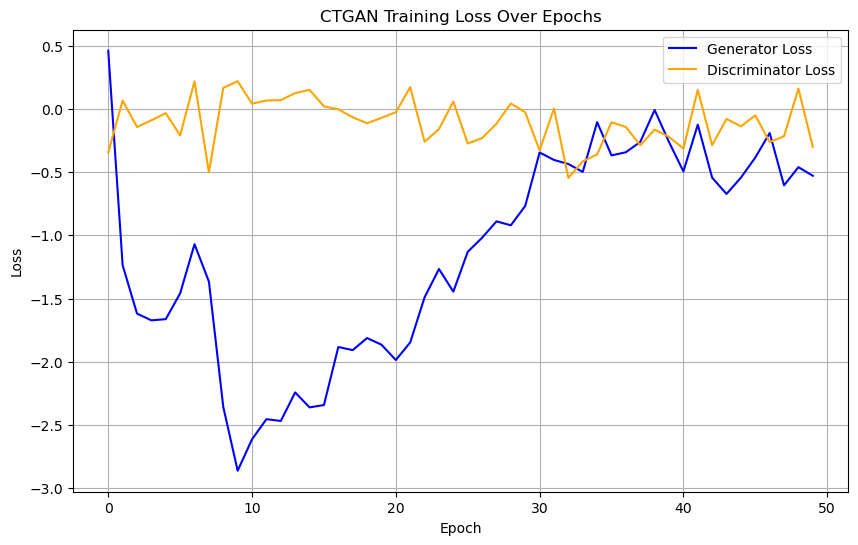

In [22]:
loss_df = ctgan.loss_values  # Retrieve the loss DataFrame

plt.figure(figsize=(10, 6))
plt.plot(loss_df['Epoch'], loss_df['Generator Loss'], label='Generator Loss', color='blue')
plt.plot(loss_df['Epoch'], loss_df['Discriminator Loss'], label='Discriminator Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('CTGAN Training Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
real_data.shape

(32561, 15)

In [15]:
synthetic_data = ctgan.sample(32561)

In [16]:
synthetic_data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,40,Private,50559,Masters,10,Never-married,?,Unmarried,White,Female,92,3,51,United-States,<=50K
1,59,Private,66989,Some-college,9,Never-married,Sales,Not-in-family,White,Male,90,5,24,United-States,<=50K
2,59,Private,58587,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,Other,Female,-13,4,40,United-States,<=50K
3,28,Private,136350,Some-college,10,Never-married,Sales,Unmarried,White,Female,84,6,28,United-States,>50K
4,23,Local-gov,13851,Some-college,9,Married-civ-spouse,Sales,Unmarried,White,Female,6369,7,12,United-States,<=50K


In [ ]:
def plot_distribution_by_sex(real_data, synthetic_data, column, sex_column='sex'):
    plt.figure(figsize=(14, 6))
    
    # Real data plot
    plt.subplot(1, 2, 1)
    sns.histplot(data=real_data, x=column, hue=sex_column, kde=True, stat="density", common_norm=False)
    plt.title(f'Distribution of {column} in Real Data by {sex_column}')
    
    # Synthetic data plot
    plt.subplot(1, 2, 2)
    sns.histplot(data=synthetic_data, x=column, hue=sex_column, kde=True, stat="density", common_norm=False)
    plt.title(f'Distribution of {column} in Synthetic Data by {sex_column}')
    
    plt.tight_layout()
    plt.show()

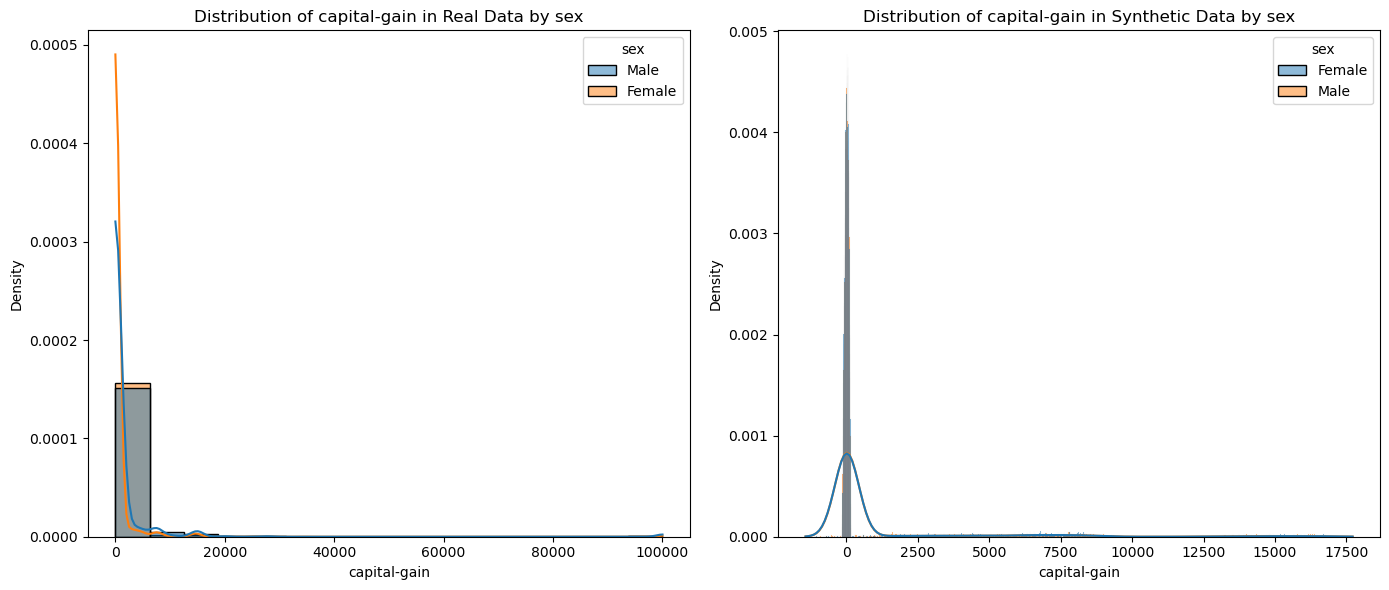

In [26]:
plot_distribution_by_sex(real_data, synthetic_data, column= "capital-gain", sex_column='sex')